# Learned Legendre Predictor
Terry Stewart, Andreas Stoeckel, Chris Eliasmith

## Overall goal:

I want to predict the future state of some system, based on the current state and other context information.  For example, predict the future state of a robot arm based on its current state and the context of what commands have been sent to the robot arm recently.  I want this prediction to be across a window of time (e.g., not just predicting what the values will be exactly 10ms into the future, but instead a prediction for the entire window of time between 0 and $\theta$ seconds into the future).  Most importantly, I want to continue to improve this prediction all the time based on the new data coming in, at the same time as I am using this prediction to perform some task (e.g., controlling the robot arm to go to some position).

## Current approaches

Right now, this can be done with online training of a neural network.  The input to the neural network is the current state and context information, and the output is the predicted future state at many points in time in the future.  When the new data is observed, we use a standard neural network backpropagation learning rule to adjust the network to be better at prediction.

One limitation of current approaches is that, for the output prediction, we have to pick a set of time points in the future at which to make predictions.  This discretizes the prediction.  However, a more important limitation is that in order to implement the standard backpropagation learning algorithm, we need to be feeding the old information into the network.  That is, if I am predicting behaviour 500ms into the future, then I need to compare the behaviour I currently observe to the value that the network predicted 500ms in the past.  This means that I have to store the old state of the network (including the old activities of the neurons) in order to run the learning rule.  This in turn means that, rather than having one neural network doing both prediction and learning, I need to have two neural networks: one that is getting the current input and is making predictions about the future, and one that is getting the old input and is learning to improve its predictions.  These neural networks would have the same connection weights (so that whatever the learning one learns is used be the one doing prediction).  This sort of weight sharing is efficient on some compute hardware (such as GPUs), but in many of the new generation of “neuromorphic” computer hardware, this sort of weight sharing is not possible (and, indeed, removing this sort of weight sharing is a big part of why neuromorphic computing hardware is more energy efficient).  It is also worth noting that the brain seems to perform this sort of learning without doing weight sharing.

Finally, current approaches discretize time immediately while the system being proposed is fully specified in continuous time (and space). While the proposed system is typically implemented in discrete time (as it runs on a digital computer), by adopting a 'continuity first' approach it results in a more tunable system (i.e., more tunable to the specifics of the discretization required).

## New invention

The invention here is to a) compress the predictions about the future into a temporal basis space, b) compress the stored information about past predictions and past neural activities into the Legendre temporal basis space, and c) define a new neural network learning rule that acts directly in that compressed space. The most novel aspect of this invention is the learning rule.  We're using the Legendre space because there’s an efficient way of getting a linear neural network to do that conversion, although other spaces are also possible.  

We give the derivation below for the Learned Legendre Predictor.  This is a single-hidden-layer neural network, and here we only learn the second layer of weights and have no non-linearity at the output.  Extensions could be made to also adjust the first layer of weights (in a manner akin to the classic back-propagation learning algorithm), but here instead we initialize those weights randomly using any existing method and leave them fixed.

We show the utility of this invention by applying it to a controller with delay. In general, it applies to any system that requires prediction of future information. 

# Derivation of the Learned Legendre Predictor

### Definitions

- $\vec{c}(t)$: the context vector (any information we are using as input to create the prediction)
- $\vec{z}(t)$: the vector to predict (m-dimensional, usually a subset of $\vec{c}(t)$)
- $\vec{a}(t)$: the activity of the neurons representing the context ($N$ dimensional)

- $q$: number of (shifted) Legendre polynomials to use for predicting the future
- $\theta$: the window size for the prediction
- $Z(t)$: the prediction of the next $\theta$ seconds, at time $t$ ($q\times m$ dimensional), using Legendre representation
- $D(t)$: the decoder weights (the connection weights from the hidden layer neurons to the output) ($N \times q \times m$)
 - Note: since this is now a tensor, so we can use Einstein tensor notation to write all this.  As an example, here is the notation for computing the output prediction $Z$ from the network, given the hidden layer neural activities $\vec{a}$ and the output connection weights $D$:
   - $Z_{qm}(t)=\vec{a}_N(t)D^N_{qm}(t)$
 - which means this, where $i$ and $j$ are index variables across $q$ and $m$, respectively.  In other words,
   - $Z[i,j](t)=\sum_N\vec{a}[N](t)D[N,i,j](t)$
- $\mathcal{P}(\tau)$: the vector of $q$ (shifted) Legendre polynomials, evaluated at $\tau$ (the LDN uses Legendre polynomials that have been shifted to the domain (0,1) rather than the typical (-1,1) domain).

### Approach

The basic approach for the derivation is to start with the classic delta learning rule (the basis for all neural network learning algorithms, including backpropagaion).  With a normal delta learning rule, you can learn to predict the future by:

- delaying your predicted output before using it to compute the error
- using the activity from the past

In other words, instead of

- $\Delta D(t) = -\kappa \vec{a}(t) \times (\vec{\hat{z}}(t)-\vec{z}(t))$
- (or, in Einstien notation: $\Delta D^N_m(t) = -\kappa a(t)^N (\hat{z}_m(t)-z_m(t))$

we do

- $\Delta D(t) = -\kappa \vec{a}(t-\tau) \times (\vec{\hat{z}}(t-\tau)-\vec{z}(t))$
- (or, in Einstien notation: $\Delta D^N_m(t) = -\kappa a^N(t-\tau) (\hat{z}_m(t-\tau)-z_m)$


But, what we would really like to do is to make and learn predictions for all values of $\tau$ (within some window $\theta$), and to do this all at once.



To do this, instead of assuming we have perfect delays everywhere, we need LDN representations of the prediction $Z(t)$ and of the activity $\vec{a}(t)$.  These LDNs can have their own $q$ values, but should have the same $\theta$ as the prediction window.
- $q_p$: the $q$ value for the prediction memory
- $M(t)$: ($m \times q \times q_p$) tensor that is an LMU for each element in $Z(t)$
- $q_a$: the $q$ value for the activity memory
- $A(t)$: ($N \times q_a$) matrix that is an LMU for the activity of each neuron in $\vec{a}(t)$

Importantly, note that $M$ is now an LDN of a Legendre representation!  That is, the output from the network is $Z$, which is a Legendre representation of the predicted behaviour of the system over a window in time $\theta$.  We take those predicted coeffecients and feed them into an LDN to produce $M$, which is the past history (over the last $\theta$ seconds) of our predictions of the behaviour from now to $\theta$ seconds into the future.

To get the activity delayed by $\tau$, we can decode that out of the LMU for activity

- $\vec{a}(t-\tau) \approx  A(t) \mathcal{P}(\tau)$ (matrix notation)
- $\vec{a}(t-\tau)^N \approx  A^N_{q_a}(t) \mathcal{P}(\tau)^{q_a}$ (Einstein notation)

To get the prediction for $\tau$ into the future, but delayed by $\tau$, we can read that out of $M$ by decoding twice:

- $\vec{z}_{predict, \tau}(t-\tau) \approx  \mathcal{P}(\tau)^T M(t)\mathcal{P}(\tau)$ (matrix notation, but assuming $m=1$ so that $M$ is a matrix, rather than a tensor which it actually is)

- $\vec{z}_{predict, \tau}(t-\tau)_m \approx  \mathcal{P}(\tau)_{q_p} M(t)^{q_p}_{m q}\mathcal{P}(\tau)^{q}$ (Einstein notation, which we're going to use from here on)

From that, we can generate our error by subtracting from $\vec{z}(t)$.  But that's not the error for the function we're learning!  Our output needs to represent $Z(t)$, so we also need to project our error back into the LMU space.  We need a new indexing variable for this, so we'll use $q_r$ (for *result*), but it will always be $q_r = q$.

- $\bigg(\mathcal{P}(\tau)_{q_p} M(t)^{q_p}_{m q}\mathcal{P}(\tau)^{q} - z_m(t)\bigg)\mathcal{P}(\tau)_{q_r}$

Except that's not quite right either, since the Legendre polynomials are not an orthonormal space.  They are orthogonal, but not normalized.  So we need a scaled version of them.  The scaling factor is $2i+1$, so we define $S_{q_r}^{q_r}$ as a ${q_r} \times {q_r}$ diagonal matrix with $S[i,i] = 2i+1$.  



So for one particular $\tau$, our learning rule is:

- $\Delta D(t)^N_{q_r m} = -\kappa A^N_{q_a}(t) \mathcal{P}(\tau)^{q_a} \bigg(\mathcal{P}(\tau)_{q_p} M(t)^{q_p}_{m q}\mathcal{P}(\tau)^{q} - z_m(t)\bigg)\mathcal{P}(\tau)_{q_r} S_{q_r}^{q_r}$


### Integrating over time


But, we want to have the system learn at all $\tau$ values inside the $\theta$ window. So, we integrate:

- ${\displaystyle\Delta D(t)^N_{q_r m} =  \int_0^1 -\kappa A^N_{q_a}(t) \mathcal{P}(\tau)^{q_a} \bigg(\mathcal{P}(\tau)_{q_p} M(t)^{q_p}_{m q}\mathcal{P}(\tau)^{q} - z_m(t)\bigg)\mathcal{P}(\tau)_{q_r} S_{q_r}^{q_r} d\tau }$


Let's do some rearranging

- ${\displaystyle\Delta D(t)^N_{q_r m} =  -\kappa A^N_{q_a}(t) \int_0^1 \mathcal{P}(\tau)^{q_a} \bigg(\mathcal{P}(\tau)_{q_p} M(t)^{q_p}_{m q}\mathcal{P}(\tau)^{q} - z_m(t)\bigg)\mathcal{P}(\tau)_{q_r} S_{q_r}^{q_r} d\tau }$

- ${\displaystyle\Delta D(t)^N_{q_r m} =  -\kappa A^N_{q_a}(t) \int_0^1 \mathcal{P}(\tau)^{q_a} \mathcal{P}(\tau)_{q_p} M(t)^{q_p}_{m q}\mathcal{P}(\tau)^{q}\mathcal{P}(\tau)_{q_r} S_{q_r}^{q_r} - \mathcal{P}(\tau)^{q_a} z_m(t)\mathcal{P}(\tau)_{q_r} S_{q_r}^{q_r} d\tau }$

- ${\displaystyle\Delta D(t)^N_{q_r m} =  -\kappa A^N_{q_a}(t) \bigg( \int_0^1 \mathcal{P}(\tau)^{q_a} \mathcal{P}(\tau)_{q_p} M(t)^{q_p}_{m q}\mathcal{P}(\tau)^{q}\mathcal{P}(\tau)_{q_r} S_{q_r}^{q_r}d\tau - \int_0^1\mathcal{P}(\tau)^{q_a} z_m(t)\mathcal{P}(\tau)_{q_r} S_{q_r}^{q_r} d\tau } \bigg)$

Since $M$ and $z$ are not dependent on $\tau$, we can pull them out of the integral.

- ${\displaystyle\Delta D(t)^N_{q_r m} =  -\kappa A^N_{q_a}(t) \bigg( M(t)^{q_p}_{m q} \int_0^1 \mathcal{P}(\tau)^{q_a} \mathcal{P}(\tau)_{q_p} \mathcal{P}(\tau)^{q}\mathcal{P}(\tau)_{q_r} S_{q_r}^{q_r}d\tau - z_m(t) \int_0^1\mathcal{P}(\tau)^{q_a} \mathcal{P}(\tau)_{q_r} S_{q_r}^{q_r} d\tau } \bigg)$


What can we do with these integrals?

Well, the second one is really pretty.  

$\int_0^1\mathcal{P}(\tau)^{q_a} \mathcal{P}(\tau)_{q_r} S_{q_r}^{q_r} d\tau$

That's the integral of two Legendre polynomials multiplied with each other across their entire size (remember we're dealing with shifted Legendre polynomials here, so the limits are 0 to 1, not -1 to 1 as would be standard).  Since they're orthogonal, all the off-diagonals must be 0.  The elements along the diagonal are the Legendre polynomials multiplied by themselves, along with a nice convenient scaling factor.

So that means this is just the identity matrix!  

Well, if $q_r = q_a$ it's the identity matrix.  Otherwise it's a $q_r \times q_a$ chunk of the identity matrix.

$\int_0^1\mathcal{P}(\tau)^{q_a} \mathcal{P}(\tau)_{q_r} S_{q_r}^{q_r} d\tau = \delta^{q_a}_{q_r}$


What about the second one?  We can at least pull out $S_{q_r}^{q_r}$ and we're left with

$Q^{q_a q}_{q_p q_r} = \int_0^1 \mathcal{P}(\tau)^{q_a} \mathcal{P}(\tau)_{q_p} \mathcal{P}(\tau)^{q}\mathcal{P}(\tau)_{q_r}d\tau$

This is a $q_a \times q \times q_p \times q_r$ tensor, where each element is the result of computing the integral of four Legendre polynomials multiplied together.  This tensor is not dependent on any observation, so it can be precomputed:

In [2]:
import numpy as np
import itertools
from numpy.polynomial.legendre import Legendre

def generate_quad_integrals(q):
    def quad(i, j, m, n):
        li, lj, lm, ln = (Legendre([0] * k + [1]) for k in (i, j, m, n))
        L = (li * lj * lm * ln).integ()
        # the desired result is (L(1) - L(-1)) / 2 (as this is for non-shifted Legendre)
        #  but since L(1) == -L(-1), this is just L(1)
        return L(1)  

    w = np.zeros((q, q, q, q))
    for i in range(q):
        for j in range(i, q):
            for m in range(j, q):
                for n in range(m, q):
                    # skip indices guranteed to be 0
                    if (i+j+m-n >= 0) and ((i+j+m-n) % 2 == 0):
                        v = quad(i, j, m, n)
                        for index in itertools.permutations([i, j, m, n]):
                            w[index] = v
    return w

q = 6
Q = generate_quad_integrals(q)

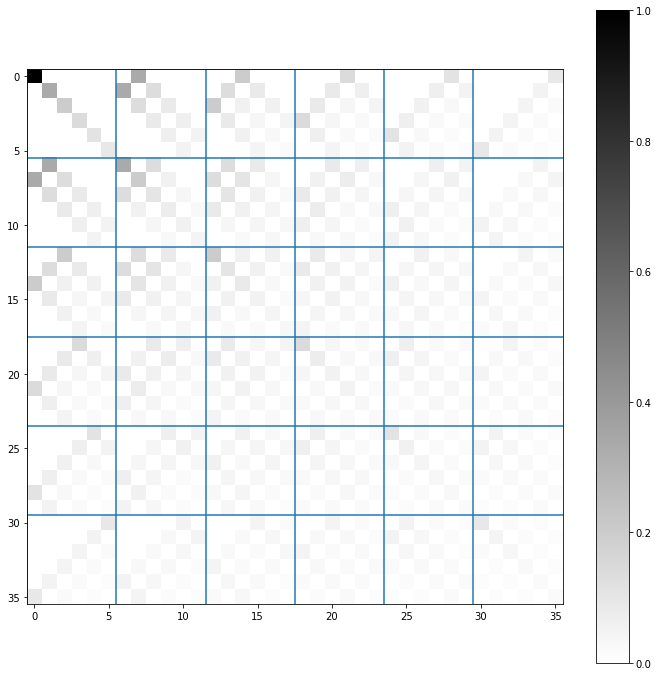

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.imshow(Q.reshape(q*q,q*q), cmap='gray_r')
for i in range(q):
    plt.axvline(i*q-0.5)
    plt.axhline(i*q-0.5)    
plt.colorbar()
plt.show()

So, once we pre-compute $Q^{q_a q}_{q_p q_r}$ we are left with this learning rule:

- $\Delta D(t)^N_{q_r m} =  -\kappa A^N_{q_a}(t) \bigg( M(t)^{q_p}_{m q} Q^{q_a q}_{q_p q_r} S_{q_r}^{q_r}- z_m(t)\delta^{q_a}_{q_r} \bigg)$

We can also roll $S$ into $Q$ if we want to save a bit of compuation.  The result is a simple linear learning rule that just depends on the current observation $z$ and the contents of the $A$ and $M$ LDNs.

This will learn to predict the future trajectory of $z$ across the whole time window.


$\Delta D(t)^N_{q_r m} =  -\kappa A^N_{q_a}(t) \bigg( M(t)^{q_p}_{m q} Q^{q_a q}_{q_p q_r} S_{q_r}^{q_r}- z_m(t)\delta^{q_a}_{q_r} \bigg)$

Combining zd: zd = np.einsum("mq, aq->maq", z, d)
$\Delta D(t)^N_{q_r m} =  -\kappa A^N_{q_a}(t) \bigg( M(t)^{q_p}_{m q} Q^{q_a q}_{q_p q_r} S_{q_r}^{q_r}- (z\delta)^{q_a}_{m q_r} \bigg)$

$\Delta D(t)^N_{q_r m} =  -\kappa A^N_{q_a}(t) \bigg( M(t)^{q_p}_{m q} (QS)^{q_a}_{q_p} - (z\delta)^{q_a}_{m q_r} \bigg)$

$\Delta D(t)^N_{q_r m} =  -\kappa A^N_{q_a}(t) \bigg( (MQS)^{q_a}_{m q} - (z\delta)^{q_a}_{m q_r} \bigg)$

$\Delta D(t)^N_{q_r m} =  -\kappa A^N_{q_a}(t) \bigg( (MQS - z\delta)^{q_a}_{m q_r} \bigg)$

$\Delta D(t)^N_{q_r m} =  \bigg(-\kappa A(MQS - z\delta) \bigg)^N_{q_r m}$

## Application 1: Generalizing P and PD Control to deal with delays and other dynamics

On its own, the LLP is just a network that learns to make predictions.  To have those predictions be useful, we need to take the output of the LLP and use it for something.

In particular, we note that if we have a prediction of how a motor is going to behave in the near future, then we can make use of that to control it better.  In particular, many motors (and other physical systems) have delays: when you send a signal to the motor, it does not respond immediately, and it instead may have some delay time, and may have some internal dynamics (such as inertia).  If this can be taken into account, then control can be improved.  

The simplest way to do this is to use the predicted future value as part of an existing control system.  For example, in standard Proportional control, the signal sent to control a motor is:

$u(t) = K_p(z_{desired}(t) - z_{actual}(t))$

We could instead use the LLP's predicted future position of the arm $\tau$ seconds into the future instead of $z_{actual}$:

$u(t) = K_p(z_{desired}(t) - Z(t)\mathcal{P}(\tau))$

Furthermore, since there is also a matrix $\mathcal{D}$ which computes the derivative of the Legendre polynomials, we can extend this to Proportional Derivative control with:

$u(t) = K_p(z_{desired}(t) - Z(t)\mathcal{P}(\tau)) + K_d(\dot z_{desired}(t) - Z(t)\mathcal{D}\mathcal{P}(\tau))$

The result is a controller that learns to deal with delays and other dynamics in the system being controlled (as long as that delay is less than $\tau$).



## Application 2: Predicting the desired signal as well

One problem with Application 1 is that, if it performs correctly, the actual behaviour of the system will be $\tau$ seconds behind where we want it to be (since the subtraction is between the desired value right now ($z_{desired}(t)$) and the predicted value $\tau$ seconds from now.  Instead, it would be better to use the desired value $\tau$ seconds from now.

Fortunately, we can do this by just having a separate LLP that learns to predict the future of $z_{desired}$.  This requires no changes to anything in the above derivation: we just have one system that learns the future of the system being controlled ($Z(t)$), and one that learns the future of the desired signal that the motor is supposed to follow ($Z_{desired}(t)$).

$u(t) = K_p(Z_{desired}(t)\mathcal{P}(\tau) - Z(t)\mathcal{P}(\tau))$

$u(t) = K_p(Z_{desired} - Z(t))\mathcal{P}(\tau))$

or, for the PD case, we have

$u(t) =  K_p(Z_{desired} - Z(t))\mathcal{P}(\tau)) +  K_d(Z_{desired} - Z(t))\mathcal{D}\mathcal{P}(\tau))$



indeed, since $K_p$, $\mathcal{P}(\tau)$, and $\mathcal{D}$ are all constant linear values, the whole control system can be collapsed to

$u(t) =  (Z_{desired} - Z(t))W$

where $W$ is a matrix.  By adjusting $W$, we can have PD control at any point $\tau$.  Furthermore, we could also have PD control at all points $\tau$ between 0 and $\theta$, or we can scale by different weights in order to smoothly emphasize some $\tau$ values more than others.


## Notes

- While this approach is derived based on Legendre polynomials, other basis spaces would also work and produce similar results
- While this derivation considers changing only output weights, extensions using backpropagation to determine input weights are considered as straightforward.
- While the derivation considers a single layer network, extension to multiple layers would follow from use of backpropagation.
- While the application here is to handling delay in a controlled system, the invention applies to any system requiring temporal prediction.
- While the application here is demonstrating online learning to find the predictor, offline learning is a simple extension.
